https://www.kaggle.com/elainexia/netflix-movie-recommendation/data?

# 환경 설정

In [7]:
#이 Python 3 환경에는 유용한 분석 라이브러리가 많이 설치되어 있습니다.
# kaggle / python Docker 이미지로 정의됩니다 : https://github.com/kaggle/docker-python
# 예를 들어,로드 할 수있는 몇 가지 유용한 패키지가 있습니다.

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 입력 데이터 파일은 읽기 전용 "../input/"디렉토리에서 사용할 수 있습니다.
# 예를 들어, 이것을 실행하면 (실행을 클릭하거나 Shift + Enter를 눌러) 입력 디렉토리 아래의 모든 파일을 나열합니다.
import os
for dirname, _, filenames in os.walk('data/Netflix'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# "Save & Run All"을 사용하여 버전을 생성 할 때 출력으로 보존되는 현재 디렉토리 (/ kaggle / working /)에 최대 5GB를 쓸 수 있습니다.
# 임시 파일을 / kaggle / temp /에 쓸 수도 있지만 현재 세션 외부에 저장되지는 않습니다.

In [8]:
# 이것은 전체 ipython 노트북을 실행하는 데 걸리는 시간을 아는 것입니다.
from datetime import datetime
# globalstart = datetime.now()
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

# 데이터설명


**CustomerID, Rating, Date**

- MovieID의 범위는 1에서 17770까지 순차적입니다.
- CustomerID의 범위는 1에서 2649429까지이며 간격이 있습니다. 480189 명의 사용자가 있습니다.
- 등급은 1에서 5까지 별 5 개 (통합) 등급입니다.
- 날짜 형식은 YYYY-MM-DD입니다.


**"movie_titles.txt"의 영화 정보는 다음 형식입니다.

MovieID, YearOfRelease, Title

- MovieID는 실제 Netflix 영화 ID 또는 IMDB 영화 ID와 일치하지 않습니다.
- YearOfRelease의 범위는 1890 년부터 2005 년까지이며해당 DVD 의 릴리스에 해당 할 수 있으며 반드시 극장 릴리스가 아닐 수도 있습니다.
- 제목은 Netflix 영화 제목이며다른 사이트에서 사용되는 제목과 일치하지 않을 수 있습니다. 제목은 영어로되어 있습니다.

**"qualifying.txt"**
- 영화 ID,콜론, 고객 ID 및 평가 날짜를 나타내는 행으로 구성되며 해당 영화 ID에 대해 한 줄에 하나씩 있습니다.
- 영화 및 고객 ID는 교육 세트에 포함되어 있습니다. 물론등급은 보류됩니다. 파일에 빈 줄이 없습니다.


**Netflix Prize**  
- 프로그램은 교육 데이터 세트의 정보를 기반으로 고객 이 적격 데이터 세트에서 영화에 부여한 모든 등급을 예측해야합니다.

- 제출 한 예측 파일의 형식은자격을 갖춘 데이터 세트 의 영화 및 고객 ID, 날짜 순서를 따릅니다 . 그러나 예상 등급은해당 고객 ID (및 날짜)를 한 줄에 하나씩 대신합니다.

예를 들어 적격 데이터 세트가 다음과 같은 경우 <br>

111 : <br>

3245,2005-12-19 <br>

5666,2005-12-23 <br>

6789,2005-03-14 <br>
 
이는 고객 3245가 <br>
2005 년 12 월 19 일에 영화 111 개의 별 3.0 개를 평가했을 것이고, 고객 5666은 <br>
2005 년 12 월 23 일에 별 3.4 개로 약간 더 높게 평가했을 것이라고 예측합니다. <br>

**적격**
- 데이터 세트의 모든 영화에 대해 모든 고객을 예측해야합니다 .


**"probe.txt"**
- 이 텍스트 파일에는 영화 ID, 콜론,고객 ID (해당 영화 ID에 대해 한 줄에 하나씩)를 나타내는 줄이 포함되어 있습니다 .

MovieID1 : <br>

CustomerID11 <br>

CustomerID12 <br>


**IMDb**

- 영화 데이터 세트에는 영화 설명, 평균 등급, 투표 수, 장르 등의 속성이있는 85,855 개의 영화가 포함됩니다.

- 등급 데이터 세트에는 인구 통계 학적 관점에서 85,855 개의 등급 세부 정보가 포함됩니다.

- 이름 데이터 세트에는 출생 세부 정보, 사망 세부 정보, 키, 배우자, 자녀 등과 같은 개인 속성을 가진 297,705 명의 출연진이 포함됩니다.

- 타이틀 주체 데이터 세트에는 IMDb 타이틀 ID, IMDb 이름 ID, 영화에서의 중요도 순서, 역할 및 

# Import Data

## 1. Netflix 사용자 대 영화 평가 데이터 가져 오기

In [9]:
start = datetime.now()

# if os.path.isfile('data.csv'):
#     os.remove('data.csv')

if not os.path.isfile('data1.csv'):
# 읽기 전에 'data.csv'파일을 만듭니다.
    # 넷플릭스의 모든 파일을 읽고 하나의 큰 파일 ( 'data.csv')에 저장합니다.
    # 4 개의 파일을 각각 읽고 각 등급을 전역 파일 'train.csv'에 추가합니다.    
    data = open('data1.csv', mode='w')
    row = list()
    files=['combined_data_1.txt','combined_data_2.txt', 
           'combined_data_3.txt', 'combined_data_4.txt']
    for file in files:
        print("Reading ratings from {}...".format(file))
        with open(file) as f:
            for line in f: 
                del row[:] # 당신은 이것을 할 필요가 없습니다.
                line = line.strip()
                if line.endswith(':'):
                    # 아래는 다른 영화가 나타날 때까지이 영화에 대한 등급입니다.
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print("Done.\n")
    data.close()
print('Time taken :', datetime.now() - start)

SyntaxError: invalid syntax (<ipython-input-9-df1048bcfe67>, line 19)

In [90]:
print("creating the dataframe from data1.csv file..")
ratings = pd.read_csv('data1.csv', sep=',', 
                       names=['movie', 'user','rating','date'])
ratings.date = pd.to_datetime(ratings.date)
print('Done.\n')

# 시간에 따라 등급을 정하고 있습니다.
print('Sorting the dataframe by date..')
ratings.sort_values(by='date', inplace=True)
print('Done..')

creating the dataframe from data1.csv file..
Done.

Sorting the dataframe by date..
Done..


In [93]:
import pandas as pd

In [96]:
ratings

.to_csv('ratings.csv', index=False, encoding='cp949')

### 10% 상위 10K 영화와 함께 상위 1K 사용자 샘플

In [11]:
# 열 이름 변경
ratings.rename(columns={'movie':'movieId',
                          'user':'userId',
                          'date':'timestamp'}, 
                 inplace=True)

In [12]:
ratings.shape

(100480507, 4)

In [13]:
ratings.head()

,movieId,userId,rating,timestamp
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


### 많이 이용하는 이용하는 고객을 가져오기 위해 top 10

In [14]:
# 상위 10K 영화가있는 상위 1K 사용자 샘플
g = ratings.groupby('userId')['rating'].count() # 고객 그룹화, 등급 카운팅
top_users = g.sort_values(ascending=False)[:1000] # 위에서 한것을 정렬 하고 10% 천명
top_users.shape

g = ratings.groupby('movieId')['rating'].count() # 영화 그룹화, 등급 카운팅
top_movies = g.sort_values(ascending=False)[:10000] # 위에서 한것을 정렬 하고 10% 천명
top_movies.shape

top_r = ratings.join(top_users, rsuffix='_r', how='inner', on='userId') #  인어 조인

ratings_sample = top_r.join(top_movies, rsuffix='_r', how='inner', on='movieId')

top_r.shape, ratings_sample.shape

((2874642, 5), (2647997, 6))

In [15]:
ratings_sample.head()

,movieId,userId,rating,timestamp,rating_r,rating_r
91241995,16242,2248080,3,1999-12-30,3523,178068
91314335,16242,10268,4,2000-06-08,2799,178068
91234237,16242,764785,3,2000-01-17,2469,178068
91346802,16242,1398256,5,2001-01-17,2504,178068
91265095,16242,1902838,2,2002-06-22,4407,178068


## IMDB 영화 메타 데이터 가져 오기

In [16]:
imdb_file = 'IMDb movies.csv'

imdb_df = pd.read_csv(imdb_file)

imdb_df.head()

C:\Anaconda3_64\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,...,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,NaN,NaN,NaN,7.0,7.0
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,NaN,NaN,NaN,NaN,5.0,2.0
3,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,446,$ 45000,NaN,NaN,NaN,25.0,3.0
4,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",...,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2237,NaN,NaN,NaN,NaN,31.0,14.0


## 3. Netflix 영화 ID를 타이틀 데이터로 가져 오기

In [17]:
title_df = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['movie', 'year', 'title'])
title_df.head(10)

,movie,year,title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW
5,6,1997.0,Sick
6,7,1992.0,8 Man
7,8,2004.0,What the #$*! Do We Know!?
8,9,1991.0,Class of Nuke 'Em High 2
9,10,2001.0,Fighter


In [18]:
title_df.rename(columns={'movie':'movieId'}, inplace=True)

In [19]:
# Netflix user to movie rating data
ratings.head()
# Netflix movie ID to title data
title_df.head()
# IMDB movie metadata
imdb_df.head(1)

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,...,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,NaN,NaN,NaN,NaN,1.0,2.0


In [20]:
ratings.merge(title_df, left_on='movieId', right_on='movieId').head()

,movieId,userId,rating,timestamp,year,title
0,10341,510180,4,1999-11-11,1996.0,Ponette
1,10341,535765,4,2000-01-06,1996.0,Ponette
2,10341,1434685,5,2000-01-07,1996.0,Ponette
3,10341,1308236,3,2000-01-08,1996.0,Ponette
4,10341,1983971,3,2000-01-08,1996.0,Ponette


In [21]:
title_df.head()

,movieId,year,title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW


# 탐색 적 분석

## Netflix와 IMDB 간의 중복


- 넷플릭스 타이틀 : 총 17,770 개
- IMDB 데이터 세트의 영화와 Netflix 타이틀을 내부 결합한 후 총 10,247 개의 영화가 있습니다. Netflix에있는 영화의 거의 40 %가 IMDB에 없습니다.

In [22]:
# 겹침
pd.merge(title_df, imdb_df, how = 'inner', left_on = 'title', right_on = 'title').shape

(4876, 24)

In [23]:
title_df.shape

(17770, 3)

## 15% 상위 15 개 사용자 및 상위 15 개 영화에 대한 등급

In [24]:
ratings_sample.head()

,movieId,userId,rating,timestamp,rating_r,rating_r
91241995,16242,2248080,3,1999-12-30,3523,178068
91314335,16242,10268,4,2000-06-08,2799,178068
91234237,16242,764785,3,2000-01-17,2469,178068
91346802,16242,1398256,5,2001-01-17,2504,178068
91265095,16242,1902838,2,2002-06-22,4407,178068


In [25]:
# 교차표(crosstab)

In [26]:
g = ratings_sample.groupby('userId')['rating'].count()
top_user = g.sort_values(ascending=False)[:15]

g = ratings_sample.groupby('movieId')['rating'].count()
top_movies = g.sort_values(ascending=False)[:15]

top_r = ratings_sample.join(top_users, rsuffix='_r', how='inner', on='userId')

top_r = top_r.join(top_movies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,607,798,1905,2862,4306,9960,10042,11283,12918,13728,14312,14410,14691,15107,16384
userId,,,,,,,,,,,,,,,
1333,2.0,4.0,2.0,4.0,5.0,2.0,3.0,4.0,1.0,5.0,2.0,2.0,2.0,2.0,3.0
3321,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0
3998,5.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0
5980,NaN,3.0,5.0,3.0,5.0,NaN,NaN,5.0,5.0,3.0,3.0,4.0,2.0,4.0,NaN
10268,4.0,3.0,3.0,5.0,3.0,5.0,4.0,4.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2637886,3.0,4.0,4.0,4.0,5.0,NaN,4.0,5.0,3.0,4.0,3.0,2.0,5.0,5.0,3.0
2640278,3.0,3.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0
2640550,4.0,3.0,5.0,3.0,5.0,3.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0


In [27]:
top_r.head()

,movieId,userId,rating,timestamp,rating_r,rating_r,rating_r,rating_r
82148127,14691,2248080,4,1999-12-30,3523,140763,3523,977
82205407,14691,10268,5,2000-01-06,2799,140763,2799,977
82142036,14691,764785,5,2000-01-06,2469,140763,2469,977
82230994,14691,1398256,5,2000-01-07,2504,140763,2504,977
82166402,14691,1902838,3,2000-03-20,4407,140763,4407,977


In [28]:
top_r.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14506 entries, 82148127 to 9877558
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   movieId    14506 non-null  int64         
 1   userId     14506 non-null  int64         
 2   rating     14506 non-null  int64         
 3   timestamp  14506 non-null  datetime64[ns]
 4   rating_r   14506 non-null  int64         
 5   rating_r   14506 non-null  int64         
 6   rating_r   14506 non-null  int64         
 7   rating_r   14506 non-null  int64         
dtypes: datetime64[ns](1), int64(7)
memory usage: 1020.0 KB


In [29]:
# 사용자와 영화를 0에서 고유 한 수의 사용자 / 영화로 인코딩



In [31]:
from sklearn.preprocessing import LabelEncoder

In [65]:
# Encode the user and movie from 0 to distinct number of users / movies
user_enc = LabelEncoder() # 값을 수치화 시키기 위해 
ratings_sample['user_enc'] = user_enc.fit_transform(ratings_sample['userId'].values)
n_users = ratings_sample['user_enc'].nunique()
item_enc = LabelEncoder() # 값을 수치화 시키기 위해  
ratings_sample['movie_enc'] = item_enc.fit_transform(ratings_sample['movieId'].values)
n_movies = ratings_sample['movie_enc'].nunique() # 유니크한 value의 개수를 나타냄
ratings_sample['rating'] = ratings_sample['rating'].values.astype(np.float32)
# 낮은 숫자는 비정상 범위에 있습니다. 기본적으로 지수에는 충분히 낮아질만큼 충분한 범위가 
# 없으므로 값이 낮아지면 점차적으로 중요한 비트가 손실됩니다. 이를 "점진적 언더 플로"라고합니다.
# 그럼 위에 말은 float32를 적용한 이유가 언더 언더플로를 예방 하기 위해서?

min_rating = min(ratings_sample['rating'])
max_rating = max(ratings_sample['rating'])

In [66]:
ratings_sample.head()

,movieId,userId,rating,timestamp,rating_r,rating_r,user_enc,movie_enc
91241995,16242,2248080,3.0,1999-12-30,3523,178068,846,9088
91314335,16242,10268,4.0,2000-06-08,2799,178068,4,9088
91234237,16242,764785,3.0,2000-01-17,2469,178068,302,9088
91346802,16242,1398256,5.0,2001-01-17,2504,178068,546,9088
91265095,16242,1902838,2.0,2002-06-22,4407,178068,718,9088


In [67]:
n_users, n_movies, min_rating, max_rating

(1000, 10000, 1.0, 5.0)

In [70]:
ratings_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2647997 entries, 91241995 to 86116872
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   movieId    int64         
 1   userId     int64         
 2   rating     float32       
 3   timestamp  datetime64[ns]
 4   rating_r   int64         
 5   rating_r   int64         
 6   user_enc   int64         
 7   movie_enc  int64         
dtypes: datetime64[ns](1), float32(1), int64(6)
memory usage: 171.7 MB


# Embedding

In [82]:
X = ratings_sample[['user_enc', 'movie_enc']].values
y = ratings_sample['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2383197, 2), (264800, 2), (2383197,), (264800,))

In [89]:
X_train

array([[ 777, 8575],
       [ 662, 4921],
       [  23, 9166],
       ...,
       [ 681, 1480],
       [ 909, 4182],
       [ 185, 3166]], dtype=int64)

In [83]:
n_factors = 50 
X_train_arry = [X_train[:, 0 ], X_train[:, 1]]
x_test_arry = [X_test[:, 0], X_test[:, 1]]

In [84]:
X_train_arry

[array([777, 662,  23, ..., 681, 909, 185], dtype=int64),
 array([8575, 4921, 9166, ..., 1480, 4182, 3166], dtype=int64)]

In [85]:
x_test_arry

[array([157, 821, 548, ..., 571, 914, 285], dtype=int64),
 array([7257,  660, 4410, ..., 5500, 1054, 5263], dtype=int64)]

### ratings('movieId', 'userId', 'rating', 'timestamp')

In [30]:
data

,movieId,userId,rating,timestamp
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11
...,...,...,...,...
49939086,8993,2183787,4,2005-12-31
42072268,7430,258170,4,2005-12-31
47098649,8467,1534359,5,2005-12-31
55621336,10168,2543295,2,2005-12-31


In [35]:
data['rating'].value_counts()

4    33750958
3    28811247
5    23168232
2    10132080
1     4617990
Name: rating, dtype: int64

In [45]:
data['rating'].describe().round()

count    100480507.0
mean             4.0
std              1.0
min              1.0
25%              3.0
50%              4.0
75%              4.0
max              5.0
Name: rating, dtype: float64

In [37]:
data['movieId'].value_counts()

5317     232944
15124    216596
14313    200832
15205    196397
1905     193941
          ...  
4806         13
11344        10
6256         10
11148         5
13755         3
Name: movieId, Length: 17770, dtype: int64

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100480507 entries, 56431994 to 25464092
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   movieId    int64         
 1   userId     int64         
 2   rating     int64         
 3   timestamp  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 6.2 GB


In [46]:
data['movieId'].describe().round()

count    100480507.0
mean          9071.0
std           5132.0
min              1.0
25%           4677.0
50%           9051.0
75%          13635.0
max          17770.0
Name: movieId, dtype: float64

In [56]:
rating_df.merge(title_df, left_on='movie', right_on='movie').head()

Drama                          12543
Comedy                          7693
Comedy, Drama                   4039
Drama, Romance                  3455
Comedy, Romance                 2508
                               ...  
Fantasy, Mystery, Action           1
Mystery, Sci-Fi, Crime             1
Western, Comedy, Drama             1
Musical, Animation, Fantasy        1
Drama, Comedy, Sci-Fi              1
Name: genre, Length: 1257, dtype: int64

In [57]:
title_df.head()

(85855,)

In [88]:
merge.shape

(4876, 24)

In [89]:
merge

,movieId,year_x,title,imdb_title_id,original_title,year_y,date_published,genre,duration,country,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,6,1997.0,Sick,tt2172055,Sick,2012,2015-01-30,"Horror, Sci-Fi",95,Canada,...,"Christina Aceto, Richard Roy Sutton, Robert No...","Two years into the outbreak, the remaining peo...",2.8,391,NaN,NaN,NaN,NaN,8.0,10.0
1,10,2001.0,Fighter,tt0995029,Fighter,2007,2007-12-14,"Action, Drama",100,"Denmark, Sweden",...,"Semra Turan, Nima Nabipour, Cyron Melville, Mo...",Aicha attends Kung Fu at her high school in Co...,6.5,1425,$ 4000000,NaN,$ 919445,NaN,19.0,28.0
2,10,2001.0,Fighter,tt10340366,Fighter,2019,2019-07-19,"Action, Drama, Sport",95,Poland,...,"Piotr Stramowski, Mikolaj Roznerski, Katarzyna...",The story is about a MMA fighter - Tomek Janic...,3.6,120,NaN,NaN,$ 256970,NaN,2.0,NaN
3,10,2001.0,Fighter,tt2876908,Fighter,2011,2011-01-07,Action,160,India,...,"Ferdous Ahmed, Joy Badlani, Gargi Banerjee, Bi...",Suriya is a college student who lives with his...,6.3,150,$ 830000,NaN,NaN,NaN,1.0,NaN
4,20,1972.0,Seeta Aur Geeta,tt0078222,Seeta Aur Geeta,1972,1972-11-17,"Comedy, Drama, Family",162,India,...,"Dharmendra, Sanjeev Kumar, Hema Malini, Manora...",Long-suffering heiress Seeta is treated worse ...,6.8,1679,NaN,NaN,NaN,NaN,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4871,17760,2004.0,Lightning Bug,tt0363768,Lightning Bug,2004,2004-04-09,Drama,97,USA,...,"Bret Harrison, Laura Prepon, Kevin Gage, Ashle...","A drama/thriller, set in the South, about a yo...",6.5,1240,NaN,NaN,NaN,NaN,25.0,35.0
4872,17761,2003.0,Levity,tt0304328,Levity,2003,2003-10-03,"Crime, Drama",100,"USA, France",...,"Billy Bob Thornton, Morgan Freeman, Holly Hunt...","After two decades in prison for murder, a man ...",6.4,6171,$ 7500000,$ 209695,$ 723040,45.0,66.0,42.0
4873,17763,1978.0,Interiors,tt0077742,Interiors,1978,1979-01-27,Drama,92,USA,...,"Kristin Griffith, Mary Beth Hurt, Richard Jord...",Three sisters find their lives spinning out of...,7.4,17856,$ 10000000,$ 10432366,$ 10432366,67.0,119.0,54.0
4874,17764,1998.0,Shakespeare in Love,tt0138097,Shakespeare in Love,1998,1999-02-26,"Comedy, Drama, History",123,"USA, UK",...,"Geoffrey Rush, Tom Wilkinson, Steven O'Donnell...","The world's greatest ever playwright,",7.1,210981,$ 25000000,$ 100317794,$ 289317794,87.0,782.0,130.0


In [85]:
title_df

,movieId,year,title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004.0,Fidel Castro: American Experience
17767,17768,2000.0,Epoch
17768,17769,2003.0,The Company


In [73]:
data.head()

,movieId,userId,rating,timestamp,year,title
0,10341,510180,4,1999-11-11,1996.0,Ponette
1,10341,535765,4,2000-01-06,1996.0,Ponette
2,10341,1434685,5,2000-01-07,1996.0,Ponette
3,10341,1308236,3,2000-01-08,1996.0,Ponette
4,10341,1983971,3,2000-01-08,1996.0,Ponette


In [81]:
data_data= data.sample(1000)

<IPython.core.display.Javascript object>


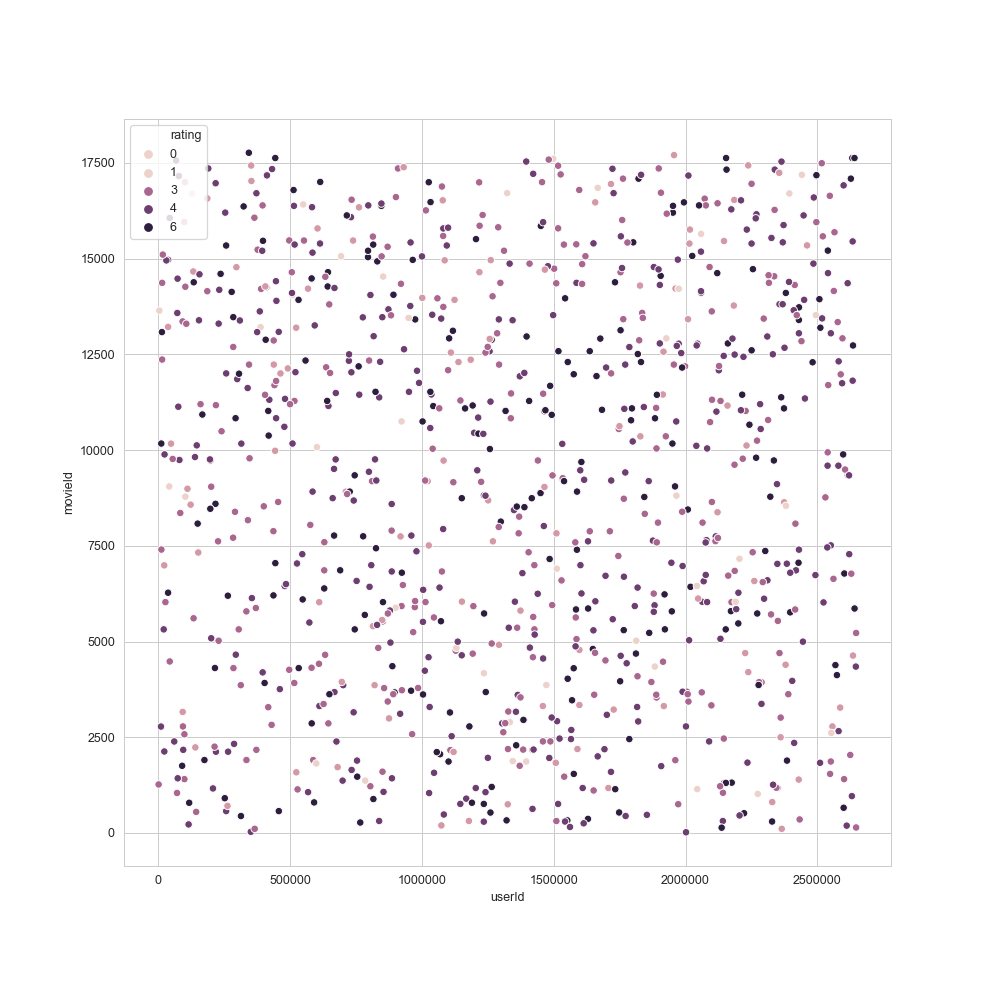

In [83]:
plt.figure(figsize=(11,11))
sns.scatterplot(x = 'userId', y = 'movieId', hue = 'rating', data = data_data)

In [84]:
title_df

,movieId,year,title
0,1,2003.0,Dinosaur Planet
1,2,2004.0,Isle of Man TT 2004 Review
2,3,1997.0,Character
3,4,1994.0,Paula Abdul's Get Up & Dance
4,5,2004.0,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002.0,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004.0,Fidel Castro: American Experience
17767,17768,2000.0,Epoch
17768,17769,2003.0,The Company


https://wikidocs.net/32105

In [94]:
110000/3

36666.666666666664